In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt, ticker
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost 
import joblib, gc

torch.manual_seed(0)
torch.set_num_threads(16)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [8]:
class MLP(nn.Module):

    def __init__(self,  fc1_num, fc2_num, fc3_num, dropout_rate):
        super(MLP, self).__init__()
        self.fc1_num = fc1_num
        self.fc2_num = fc2_num
        self.fc3_num = fc3_num

        # 两个全连接层
        self.fc1 = nn.Linear(fc1_num, fc2_num) # 702 -> 30
        self.fc2 = nn.Linear(fc2_num, 1)
        # self.fc3 = nn.Linear(fc3_num, 1)# 30 -> 1
        # 激活函数
        self.relu = nn.ReLU()
        # dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # 使用 xavier 的均匀分布对 weights 进行初始化
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # 使用正态分布对 bias 进行初始化
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, data):
        data = self.flatten(data)
        data = self.fc1(data) # N*30
        data = self.relu(data)
        data = self.dropout(data)
        data = self.fc2(data)
        # data = self.relu(data)
        # data = self.dropout(data)
        # data = self.fc3(data)
        # 线性激活函数，无需再进行激活
        data = data.to(torch.float)

        return data


class FactorData():

    def __init__(self, train_x, train_y):
        self.len = len(train_x)
        self.x_data = train_x
        self.y_data = train_y

    def __getitem__(self, index):
        """
        指定读取数据的方式：根据索引 index 返回 dataset[index]

        """
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


In [17]:
def prepare_data(train_parquet, stock_labels, skip_cols, n_split=5):
    
    df = pd.read_parquet(train_parquet)
    df = df[~df['target'].isnull()].reset_index(drop=True)
    df = df.drop(columns=['row_id', 'time_id'])
    df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})

    df = df[df['date_id'].isin(np.arange(0, 6))].reset_index(drop=True)
    
    feature_cols = [x for x in df.columns if x not in ['target']+skip_cols]
    category_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag', 'stock_label']

    df = df[df['stock_label'].isin(stock_labels)].reset_index(drop=True)
    
    print(df.shape)
    print(f"Stock labels: {stock_labels}")
    print(f"Trading days: {df['date_id'].nunique()}")
    print(f"Stocks: {df['stock_id'].nunique()}")
    print("Number of features:", len(feature_cols))
    print("Number of category features:", len(category_cols))
    
    scale_cols = [x for x in feature_cols if x not in category_cols]
    scaler = StandardScaler().fit(df[scale_cols])
    
    df[scale_cols] = scaler.transform(df[scale_cols])

    scaler_target = StandardScaler().fit(df[['target']])
    df[['target']] = scaler_target.transform(df[['target']])

    has_invalids = df.isnull().values.any() & np.isinf(df.values).any()
    
    if has_invalids:
        print("df has NaNs or Infs")
        print(df.isnull().sum())
        print(df.isinf().sum())
        sys.exit(1)

    df_valid = df[df['date_id']==5].reset_index(drop=True)
    rand_idx = np.random.choice(df_valid.index, size=int(len(df_valid)*0.5), replace=False)
    
    datasets = {}
    datasets[0] = {
        "train": df[df['date_id'].isin(np.arange(0, 5))].reset_index(drop=True),
        "valid_1": df_valid[~df_valid.index.isin(rand_idx)].reset_index(drop=True),
        "valid_2": df_valid[df_valid.index.isin(rand_idx)].reset_index(drop=True),
    }
    # dates_list = df['date_id'].unique()
    
    # k_fold = KFold(n_splits=n_split, shuffle=False, random_state=None)
    # kf_split = k_fold.split(dates_list)
    
    # datasets = {}
    
    # for fold, (train_idx, valid_idx) in enumerate(kf_split):
        
    #     print(f"Fold {fold+1}")
    #     fold_start = time()
        
    #     train_dates = dates_list[train_idx]
        
    #     half_valid = int(len(valid_idx)/2)
    #     valid_dates_1 = dates_list[valid_idx[:half_valid]]
    #     valid_dates_2 = dates_list[valid_idx[half_valid:]]
        
    #     print(f"Valid Dates 1: {valid_dates_1[0]} - {valid_dates_1[-1]}")
    #     print(f"Valid Dates 2: {valid_dates_2[0]} - {valid_dates_2[-1]}")
        
    #     # split train and valid set
    #     df_train_fold = df[df["date_id"].isin(train_dates)].reset_index(drop=True)
    #     df_valid_fold_1 = df[df["date_id"].isin(valid_dates_1)].reset_index(drop=True)
    #     df_valid_fold_2 = df[df["date_id"].isin(valid_dates_2)].reset_index(drop=True)
        
    #     print(f"Train  : {df_train_fold[feature_cols].shape}")
    #     print(f"Valid 1: {df_valid_fold_1[feature_cols].shape}")
    #     print(f"Valid 2: {df_valid_fold_2[feature_cols].shape}")

    #     datasets[fold] = {
    #         "train": df_train_fold,
    #         "valid_1": df_valid_fold_1,
    #         "valid_2": df_valid_fold_2,
    #     }
        
    return datasets, scaler, scaler_target, feature_cols, category_cols

    

In [18]:
train_parquet = "/home/lishi/projects/Competition/kaggle_2023/data/train_add_daily_features.parquet"

prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
ta_indicators = ['ema', 'rsi', 'cci', 'mfi', 'ad_osc', 'macd', 'macdhist', 'macdsignal']

stock_labels =[0, 1, 2]

datasets, scaler,  scaler_target, feature_cols, category_cols = prepare_data(
    train_parquet, 
    stock_labels=stock_labels, 
    skip_cols=['date_id', 'row_id'] + ta_indicators
    )

(63140, 194)
Stock labels: [0, 1, 2]
Trading days: 6
Stocks: 192
Number of features: 192
Number of category features: 4


In [19]:
# with open("feature_cols.txt", "w") as f:
#     f.write("\n".join(feature_cols))

In [20]:
save_dir = "/home/lishi/projects/Competition/kaggle_2023/data/models_192_stock_all_scale_target"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
joblib.dump(feature_cols, f"{save_dir}/feature_cols.pkl")
joblib.dump(category_cols, f"{save_dir}/category_cols.pkl")
joblib.dump(scaler, f"{save_dir}/scaler.pkl")
joblib.dump(scaler_target, f"{save_dir}/scaler_target.pkl")

['/home/lishi/projects/Competition/kaggle_2023/data/models_192_stock_all_scale_target/scaler_target.pkl']

In [21]:
# datasets[0]['train'].head()
# category_cols
# datasets[0]['valid_2'][category_cols].dtypes

In [22]:
def train_mlp(mlp_params, train_x, train_y, test_x, test_y, lr=1e-4, epoch=30, batch_size=1000, mom=0.9):
    
    model = MLP(**mlp_params)
    
    train_dataset = FactorData(train_x, train_y)
    test_dataset = FactorData(test_x, test_y)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    weight_list, bias_list = [], []
    for name, p in model.named_parameters():
        if 'bias' in name: 
            bias_list += [p] # 将所有的 bias 参数放入 bias_list 中
        else:
            weight_list += [p] # 将所有的 weight 参数放入 weight_list 中
    
    criterion = nn.MSELoss()
    test_criterion = nn.L1Loss()

    optimizer = optim.RMSprop(
        [{'params': weight_list, 'weight_decay': 1e-5},
         {'params': bias_list, 'weight_decay': 0}],
        lr=lr,
        momentum=mom)
    
    train_loss_list = []
    test_loss_list = []

    for epoch in range(1, epoch+1):
        # 测试模式
        test_loss = 0
        model.eval()
        test_batch_num = 0
        with torch.no_grad():
            for data, label in tqdm(test_loader, f'Epoch {epoch}-test ', leave=False):
                test_batch_num += 1
                data, label = data.to(torch.float), label.to(torch.float)
                y_pred = model(data)
                loss = test_criterion(y_pred, label)
                test_loss += loss.item()

        # .train() 参考 https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
        # .zero_grad() 参考 https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        train_loss = 0
        model.train()  
        train_batch_num = 0
        for data, label in tqdm(train_loader, f'Epoch {epoch}-train', leave=False):
            train_batch_num += 1
            data, label = data.to(torch.float), label.to(torch.float)
            out_put = model(data)
            loss = criterion(out_put, label)
            train_loss += loss.item()
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        train_loss_list.append(train_loss/train_batch_num)
        test_loss_list.append(test_loss/test_batch_num)

    return model, train_loss_list, test_loss_list 

In [23]:
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.015, #0.009,#0.018,
    'max_depth': 12,#9,
    'n_estimators': 800,#600,
    'num_leaves': 1024,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 16,
    'importance_type': 'gain',
    'verbose': -1,
    }

cat_params = dict(
    iterations=1200,
    learning_rate=1.0,
    depth=8,
    l2_leaf_reg=30,
    bootstrap_type='Bernoulli',
    subsample=0.66,
    loss_function='MAE',
    eval_metric = 'MAE',
    metric_period=100,
    od_type='Iter',
    od_wait=30,
    thread_count=16,
    allow_writing_files=False,
    )

mlp_params = dict(
    fc1_num=len(feature_cols), fc2_num=40, fc3_num=0, dropout_rate=0.2 
    )

In [28]:
mlp_models, mlp_train_losses, mlp_test_losses = [], [], []
lgb_models, cat_models = [], []
valid_maes = []

for fold, dataset in datasets.items():
    print(f"{'-'*10}\nFold {fold+1}\n{'-'*10}")
    fold_start = time()
    
    train_x = dataset['train'][feature_cols].values
    train_y = dataset['train']['target'].values
    
    test_x = dataset['valid_1'][feature_cols].values
    test_y = dataset['valid_1']['target'].values
    
    valid_x = dataset['valid_2'][feature_cols].values
    valid_y = dataset['valid_2']['target'].values
    
    # print("Start training MLP...")
    # mlp, train_loss_list, test_loss_list = train_mlp(
    #     mlp_params,
    #     train_x, train_y,
    #     test_x, test_y,
    #     lr=1e-4, 
    #     epoch=20, 
    #     batch_size=1000, 
    #     mom=0.9)
    
    # mlp_train_losses.append(train_loss_list)
    # mlp_test_losses.append(test_loss_list)
    # valid_pred_mlp = mlp(torch.tensor(valid_x).to(torch.float)).detach().numpy().squeeze()
    # valid_mae_mlp = mean_absolute_error(valid_y, valid_pred_mlp)
    
    # mlp_models.append(mlp)
    # joblib.dump(mlp, f"{save_dir}/mlp_fold_{fold}.pkl")
    
    print("Start training LightGBM...")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        train_x, train_y,
        eval_set=[(test_x, test_y)],
        feature_name = feature_cols,
        categorical_feature = category_cols,
        callbacks=[lgb.callback.log_evaluation(period=100)],
        )
    
    valid_pred_lgb = lgb_model.predict(valid_x)
    valid_mae_lgb = mean_absolute_error(valid_y, valid_pred_lgb)
    
    lgb_models.append(lgb_model)
    joblib.dump(lgb_model, f"{save_dir}/lgb_fold_{fold}.pkl")

    print("Start training Catboost...")
    
    cat_model = catboost.CatBoostRegressor(**cat_params)
    
    train_pool = catboost.Pool(
        data=dataset['train'][feature_cols], 
        label=dataset['train']['target'],
        feature_names=feature_cols,
        cat_features=category_cols,
        )
    
    test_pool = catboost.Pool(
        data=dataset['valid_1'][feature_cols], 
        label=dataset['valid_1']['target'],
        feature_names=feature_cols,
        cat_features=category_cols,
        )
    
    valid_pool = catboost.Pool(
        data=dataset['valid_2'][feature_cols], 
        label=dataset['valid_2']['target'],
        feature_names=feature_cols,
        cat_features=category_cols,
        )
    
    cat_model.fit( train_pool, eval_set=test_pool, verbose=100 )
    valid_pred_cat = cat_model.predict(valid_pool)
    valid_mae_cat = mean_absolute_error(valid_y, valid_pred_cat)
    
    cat_models.append(cat_model)
    joblib.dump(cat_model, f"{save_dir}/cat_fold_{fold}.pkl")
    
    # valid_pred_mlp = np.nan
    # valid_pred_mean = np.nanmean([valid_pred_mlp, valid_pred_lgb,  valid_pred_cat], axis=0) 
    # valid_mae_mean = mean_absolute_error(valid_y, valid_pred_mean)
    
    print('-'*10)
    # print(f"Valid MAE MLP: {valid_mae_mlp}")
    print(f"Valid MAE LGB: {valid_mae_lgb}")
    print(f"Valid MAE CAT: {valid_mae_cat}")
    # print(f"Valid MAE Mean: {valid_mae_mean}")
    
    valid_maes.append([valid_mae_lgb, valid_mae_cat])
    
    fold_end = time()
    print(f"{'-'*10}\nFold {fold+1} took {fold_end-fold_start:.2f} seconds.\n{'-'*10}")
    

----------
Fold 1
----------
Start training LightGBM...
[100]	valid_0's l1: 0.624449
Start training Catboost...
0:	learn: 0.6398493	test: 0.6275730	best: 0.6275730 (0)	total: 32.5ms	remaining: 39s


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6275729802
bestIteration = 0

Shrink model to first 1 iterations.
----------
Valid MAE LGB: 0.6244029997005538
Valid MAE CAT: 0.6248897400740657
----------
Fold 1 took 7.60 seconds.
----------


In [45]:
df_join = datasets[0]['valid_2'] #pd.concat([datasets[0]['valid_1'], datasets[0]['valid_2']], axis=0).reset_index(drop=True)
df_join = df_join.sort_values(by=['stock_id', 'seconds_in_bucket']).reset_index(drop=True)
df_join['lgb_pred'] = lgb_models[0].predict(df_join[feature_cols])
df_join['cat_pred'] = cat_models[0].predict(df_join[feature_cols])
df_join['target_reverse'] = scaler_target.inverse_transform(df_join[['target']])
df_join['lgb_pred_reverse'] = scaler_target.inverse_transform(df_join[['lgb_pred']])
df_join['cat_pred_reverse'] = scaler_target.inverse_transform(df_join[['cat_pred']])

# df_join[['stock_id', 'seconds_in_bucket', 'target', 'lgb_pred_reverse', 'cat_pred_reverse']].head(100)

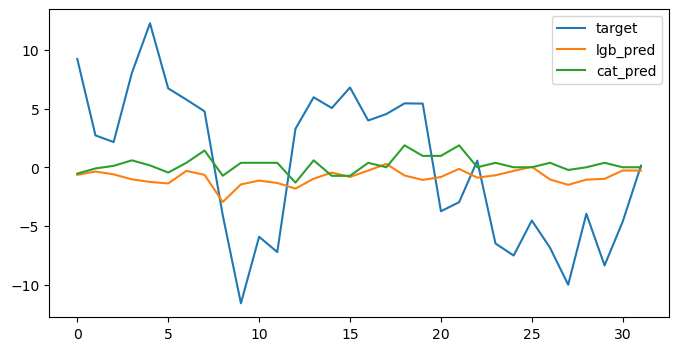

MAE LGB: 5.639525939061176; MAE CAT: 5.700553639285532


In [47]:
fig, ax = plt.subplots(figsize=(8, 4))

stock_id = 184
df_plot = df_join[df_join['stock_id']==stock_id].reset_index(drop=True)
ax.plot(df_plot['target_reverse'], label='target')
ax.plot(df_plot['lgb_pred_reverse'], label='lgb_pred')
ax.plot(df_plot['cat_pred_reverse'], label='cat_pred')
ax.legend()
plt.show()

mae_lgb = mean_absolute_error(df_plot['target_reverse'], df_plot['lgb_pred_reverse'])
mae_cat = mean_absolute_error(df_plot['target_reverse'], df_plot['cat_pred_reverse'])
print(f"MAE LGB: {mae_lgb}; MAE CAT: {mae_cat}")

In [ ]:
# plot maes as line chart
valid_maes = np.array(valid_maes)
valid_maes = pd.DataFrame(valid_maes, columns=['mlp', 'lgb', 'cat', 'mean'])

fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=valid_maes, ax=ax, marker='o', )
ax.set_title("MAE of each fold")
ax.set_xlabel("Fold")
ax.set_ylabel("MAE")

txt = [
    "Average MAE:",
    f"MLP: {valid_maes['mlp'].mean():.4f}",
    f"LGB: {valid_maes['lgb'].mean():.4f}",
    f"CAT: {valid_maes['cat'].mean():.4f}",
    f"Mean: {valid_maes['mean'].mean():.4f}", 
    ]
ax.text(0.5, 0.95, "\n".join(txt),
        transform=ax.transAxes, fontsize=12, ha='left', va='top')

fig.tight_layout()
plt.show()

In [ ]:
df_all = pd.read_parquet(train_parquet)
# df_all = df_all[['date_id', 'stock_id', 'stock_label', 'target']]

In [ ]:
mean_std = df_all.groupby(['stock_id', 'seconds_in_bucket'])['target'].std().reset_index()
mean_std.columns = ['stock_id', 'seconds_in_bucket', 'target_std']
df_all = df_all.merge(mean_std, on=['stock_id', 'seconds_in_bucket'], how='left')

In [ ]:
range_max = df_all.groupby(['stock_id', 'seconds_in_bucket'])['target'].max().reset_index()
range_min = df_all.groupby(['stock_id', 'seconds_in_bucket'])['target'].min().reset_index()

range_max_min = range_max.merge(range_min, on=['stock_id', 'seconds_in_bucket'], how='left')

range_max_min['target_range'] = range_max_min['target_x'] - range_max_min['target_y']

df_all = df_all.merge(range_max_min[['stock_id', 'seconds_in_bucket', 'target_range']], on=['stock_id', 'seconds_in_bucket'], how='left')

In [ ]:
def plot_targets(ax, df_all, stock_label, date_id, select_idx, coeff=0.1, use_std=True):
        
    df_select = df_all[(df_all['stock_label']==stock_label) & (df_all['date_id']==date_id)].reset_index(drop=True)
    stock_ids = df_select['stock_id'].unique()

    df_stock = df_select[df_select['stock_id']==stock_ids[select_idx]].reset_index(drop=True)

    df_stock['target_mlp'] = np.mean([model(torch.tensor(df_stock[feature_cols].values).to(torch.float)).detach().numpy().squeeze() for model in mlp_models],  axis=0) 
    df_stock['target_lgb'] = np.mean([model.predict(df_stock[feature_cols]) for model in lgb_models], axis=0) 
    df_stock['target_cat'] = np.mean([model.predict(df_stock[feature_cols]) for model in cat_models], axis=0)

    if use_std:
        df_stock['target_mlp'] = df_stock['target_mlp'] + df_stock['target_std'] * np.random.normal(0, 1, 1) * coeff
        df_stock['target_lgb'] = df_stock['target_lgb'] + df_stock['target_std'] * np.random.normal(0, 1, 1) * coeff
        df_stock['target_cat'] = df_stock['target_cat'] + df_stock['target_std'] * np.random.normal(0, 1, 1) * coeff

        for col in ['target_mlp', 'target_lgb', 'target_cat']:
            ratio = (df_stock[col].max() - df_stock[col].min()) / df_stock['target_range']
            df_stock[col] = df_stock[col] / ratio

    df_stock['target_mean'] = (df_stock['target_mlp'] + df_stock['target_lgb'] + df_stock['target_cat'])/3

    sns.lineplot(data=df_stock, x='seconds_in_bucket', y='target', ax=ax, label='target', linewidth=2)
    # sns.lineplot(data=df_stock, x='seconds_in_bucket', y='target_mlp', ax=ax, label='mlp')
    sns.lineplot(data=df_stock, x='seconds_in_bucket', y='target_lgb', ax=ax, label='lgb')
    sns.lineplot(data=df_stock, x='seconds_in_bucket', y='target_cat', ax=ax, label='cat')
    sns.lineplot(data=df_stock, x='seconds_in_bucket', y='target_mean', ax=ax, label='mean')

    ax.set_title(f"Stock {[stock_ids[select_idx]]}")
    ax.set_xlabel("seconds_in_bucket")
    ax.set_ylabel("target")
    ax.legend()
    ax.grid(True)

    df_mae = pd.DataFrame({
        'stock_id': [stock_ids[select_idx]],
        'mlp': [mean_absolute_error(df_stock['target'], df_stock['target_mlp'])],
        'lgb': [mean_absolute_error(df_stock['target'], df_stock['target_lgb'])],
        'cat': [mean_absolute_error(df_stock['target'], df_stock['target_cat'])],
        'mean': [mean_absolute_error(df_stock['target'], df_stock['target_mean'])],
    })
    
    return df_mae

In [ ]:
# select one stock from stock_labels in [1, 2], and plot the real and predicted targets
stock_label = 2
date_id = 25
select_idx = [3, 5, 7, 10]

In [ ]:
mae_list = []

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

for idx, ax in list(zip(select_idx, ax.flatten())):
    mae = plot_targets(ax, df_all, stock_label, date_id, idx, use_std=True)
    mae_list.append(mae)

fig.tight_layout()
plt.show()

df_mae = pd.concat(mae_list, axis=0)
df_mae

In [ ]:
mae_list = []

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

for idx, ax in list(zip(select_idx, ax.flatten())):
    mae = plot_targets(ax, df_all, stock_label, date_id, idx, use_std=False)
    mae_list.append(mae)

fig.tight_layout()
plt.show()

df_mae = pd.concat(mae_list, axis=0)
df_mae

In [ ]:
Stock id: 6
MLP	 LGB	 CAT	 Mean
4.3453	4.4442	4.3757	4.3180
Stock id: 18
MLP	 LGB	 CAT	 Mean
11.4539	10.9334	11.0389	11.1363
Stock id: 22
MLP	 LGB	 CAT	 Mean
4.8768	4.4891	4.8353	4.6734
Stock id: 42
MLP	 LGB	 CAT	 Mean
6.1704	6.1275	5.8930	6.0380

In [ ]:
Stock id: 7 NO STD
MLP	 LGB	 CAT	 Mean
4.4576	4.1274	3.7023	3.9793
Stock id: 9
MLP	 LGB	 CAT	 Mean
3.1549	3.1790	2.8340	2.9888
Stock id: 12
MLP	 LGB	 CAT	 Mean
3.9422	3.8812	3.7321	3.8083
Stock id: 15
MLP	 LGB	 CAT	 Mean
6.8013	6.8980	6.4127	6.6860

In [ ]:
Stock id: 7  Use STD
MLP	 LGB	 CAT	 Mean
4.4782	5.2288	7.5485	4.2225
Stock id: 9
MLP	 LGB	 CAT	 Mean
3.1352	5.8935	3.8554	3.4087
Stock id: 12
MLP	 LGB	 CAT	 Mean
3.9718	6.7794	4.3273	4.2339
Stock id: 15
MLP	 LGB	 CAT	 Mean
6.7006	17.2729	9.2879	8.8818

In [ ]:
mlp_models[0](torch.tensor(df_stock[feature_cols].values).to(torch.float)).detach().numpy().squeeze()
